In [1]:
#Imports
import numpy as np
import tifffile as tle
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
import os
import time
from keras.layers import *
from keras.models import Model
from keras.callbacks import *
from sklearn.metrics import confusion_matrix
import sklearn
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
from keras.layers.normalization import BatchNormalization
from skimage.filters import roberts, sobel

/home/rithwik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
#Image processing to find Water and Swimming pools
import numpy as np
import tifffile as tle
import cv2
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


def detect_swimming_pool(img, params):
    # NDWI

    # SWIMMING POOL

    kernel_heighterod = params['kernel_heighterod']
    kernel_heightdilate = params['kernel_heightdilate']
    kernel_deptherod = params['kernel_deptherod']
    kernel_depthdilate = params['kernel_depthdilate']
    thresh1 = params['thresh1']

    eroditer = params['eroditer']
    dilateiter = params['dilateiter']

    # Folder would be of train_x
    
    # y = tle.imread('../train_gt/' + i)
    x = (np.int64(img[:, :, 1]) - np.int64(img[:, :, 3])) / \
        (np.int64(img[:, :, 1]) + np.int64(img[:, :, 3])+1)
    """
 Xgreen-Xnir/Xgreen+Xnir = ndwi index if >0.55 water if >0.75 swimming pool
 """
    # 0.75 Swimming Pool
    z = np.where(x > thresh1, 7, 0)
    rgbz = np.expand_dims(z, axis=2)
    rgbz = np.where(rgbz == [0], [0, 0, 0], [7, 7, 7])

    gray = rgb2gray(rgbz)
    # EROSION
    kernel = np.ones(
        (int(kernel_heighterod), int(kernel_deptherod)), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=int(eroditer))
    # DILATION
    kernel = np.ones(
        (int(kernel_heightdilate), int(kernel_depthdilate)), np.uint8)
    dilated = cv2.dilate(eroded, kernel, iterations=int(dilateiter))

    return dilated


def detect_waterways(img, params):
        # Copy of the above kernel but using params at top

    kernel_heighterod = params['kernel_heighterod']
    kernel_heightdilate = params['kernel_heightdilate']
    kernel_deptherod = params['kernel_deptherod']
    kernel_depthdilate = params['kernel_depthdilate']
    thresh1 = params['thresh1']
    thresh2 = params['thresh2']
    eroditer = params['eroditer']
    dilateiter = params['dilateiter']

    # y = tle.imread('../train_gt/' + i)
    x = (np.int64(img[:, :, 1]) - np.int64(img[:, :, 3])) / \
        (np.int64(img[:, :, 1]) + np.int64(img[:, :, 3])+1)
    """
 Xgreen-Xnir/Xgreen+Xnir = ndwi index if >0.55 water if >0.75 swimming pool
 """
    # 0.75 Swimming Pool
    z2 = np.where(x < thresh1, x, 0)
    z = np.where(z2 > thresh2, 5, 0)
    rgbz = np.expand_dims(z, axis=2)
    rgbz = np.where(rgbz == [0], [0, 0, 0], [5, 5, 5])

    gray = rgb2gray(rgbz)
    # EROSION
    kernel = np.ones(
        (int(kernel_heighterod), int(kernel_deptherod)), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=int(eroditer))
    # DILATION
    kernel = np.ones(
        (int(kernel_heightdilate), int(kernel_depthdilate)), np.uint8)
    dilated = cv2.dilate(eroded, kernel, iterations=int(dilateiter))
    print(dilated.shape)
    return dilated


def overlap(model_array,index_array,swimming=1):
    
    if swimming:
        num=7
    else:
        num=5
        
    out=np.where(index_array==[num],index_array,model_array)
    
    return out


def attheend(input_image,model_pred):
    
    
    swimparams = {'dilateiter': 4.0,
              'eroditer': 2.0,
              'kernel_depthdilate': 4.0,
              'kernel_deptherod': 3.0,
              'kernel_heightdilate': 4.0,
              'kernel_heighterod': 5.0,
              'thresh1': 0.7511846894935733}

    waterparams = {'dilateiter': 6.0, 'eroditer': 2.0, 'kernel_depthdilate': 4.0, 'kernel_deptherod': 2.0,
               'kernel_heightdilate': 3.0, 'kernel_heighterod': 5.0, 'thresh1': 0.7801215508725782, 'thresh2': 0.5760557221266768}

    
    swimming_pools=detect_swimming_pool(input_image,swimparams)
    waterways=detect_waterways(input_image,waterparams)
    
    model_pred=overlap(model_pred,swimming_pools)
    model_pred=overlap(model_pred,waterways,0)
    
    return model_pred

In [2]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import tifffile as tiff
import os
from keras.utils import to_categorical
from skimage import io

In [3]:
#Architecture for Unet
def get_unet():
    inputs = Input((96, 96, 5))
    inputs_2 = Input((96,96,1))
    inputs_3 = Input((96,96,1))


    conv1 = Conv2D(32, 3, activation='elu', padding='same',data_format='channels_last')(inputs)
    conv1 = Conv2D(32, 3, activation='elu', padding='same')(conv1)

    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='elu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='elu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    conv3 = BatchNormalization()(conv3)


    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256,  3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up_1 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up_1, conv4])


    conv6 = Conv2D(256,  3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256,  3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128,  3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2] )
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64,  3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, 3, activation='elu', padding='same')(up9)
    conv9 = Conv2D(32,  3, activation='elu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)


    conv11 = Conv2D(64, 3, activation='elu', padding='same')(inputs_3)
    conv12 = Conv2D(64, 3, activation='elu', padding='same')(conv11)


    conv9 = concatenate([conv9,inputs_2,conv12])
    conv9 = BatchNormalization()(conv9)




    conv10 = Conv2D(10, 1,  activation='softmax')(conv9)

    model = Model(input=[inputs,inputs_2,inputs_3], output=conv10)




    return model


In [4]:
#Function to create mapping. To convert Gt to an input accepted by NN
def create_mapping(img):
    
    
        patch_size = 96
        lst=[]
        d = {0: 0, 2715: 7, 2220: 6, 2830: 8, 1110: 4, 280: 9, 95: 1, 1500: 5, 125: 2, 255: 3}
        
        dict_cnt=0

        

        im = np.copy(img)
        #print (img.shape)
        
        old_size = im.shape[:2] # old_size is in (height, width) format
        
        delta_w = patch_size * (old_size[1]//patch_size) + patch_size  - old_size[1]
        delta_h = patch_size * (old_size[0]//patch_size)+ patch_size - old_size[0]

        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        
        
        res = im[:,:,0].astype(np.float32)*.01 + im[:,:,1].astype(np.float32)*.1 + im[:,:,2].astype(np.float32)*1
        res = np.uint32(res*10)
        
        unique_vals = np.unique(res)
        
        for q in unique_vals:
            #print (q)
            if q in d:
                
                res[res==q] = d[q]
            else:
                
                print ("Not Found!")
     
            
            
        return res


In [5]:
#Fucntion to create the Output map from the input iamge
def generate_whole_mask(img,weights_path):
    #print ("from func",img.shape)
    
    patch_size = 96
    
    model = get_unet()
    
    model.load_weights(weights_path)
    
    im = np.copy(img)
    
    image=im[:,:,:]
    

    loop_1 =  img.shape[1]//patch_size
    loop_2 =  img.shape[0]//patch_size
        
    
    preds_arr = np.zeros((  img.shape[0] , img.shape[1] , 10)) 
    

    

    for h in range(loop_2):
        for w in range(loop_1):


            common_img = im[h*patch_size:(h+1)*patch_size,w*patch_size:(w+1)*patch_size,:]

            common_img = (common_img)/ 4096.0

            p1 = np.expand_dims(common_img[:,:,4],axis=2)
            p2 = np.expand_dims(common_img[:,:,3],axis=2)
            #print (common_img.shape)


            pred = model.predict([np.expand_dims(common_img,axis=0),np.expand_dims(p1,axis=0),np.expand_dims(p2,axis=0)])[0]

            #print (pred.shape)

            pred[:,:,8] = 0

            
            
            
            preds_arr[h*patch_size:(h+1)*patch_size,w*patch_size:(w+1)*patch_size,:] = pred




    return preds_arr
            

In [6]:
#Function to map the output sot the format described in the dataset
def inverse_map(pred):
    pred = np.uint8(pred)
    pred = pred[..., np.newaxis]
    pred = np.where(pred == [10], [0, 0, 0], pred)
    pred = np.where(pred == [0], [0, 0, 0], pred)
    pred = np.where(pred == [1], [150, 80, 0], pred)
    pred = np.where(pred == [2], [0, 125, 0], pred)
    pred = np.where(pred == [3], [0, 255, 0], pred)
    pred = np.where(pred == [4], [100, 100, 100], pred)
    pred = np.where(pred == [5], [0, 0, 150], pred)
    pred = np.where(pred == [6], [200, 200, 200], pred)
    pred = np.where(pred == [7], [150, 150, 255], pred)
    pred = np.where(pred == [8], [255, 255, 255], pred)
    pred = np.where(pred == [9], [255, 255, 0], pred)
    return pred

Running for Image 4.tif


/home/rithwik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


../gen_test/generated_4.tif


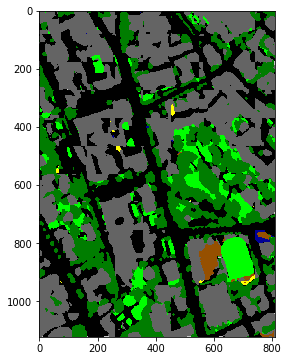

Running for Image 2.tif
../gen_test/generated_2.tif


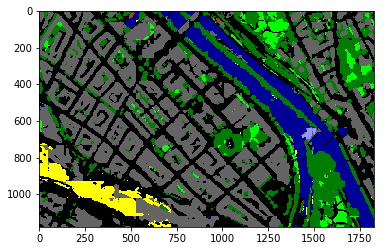

Running for Image 3.tif
../gen_test/generated_3.tif


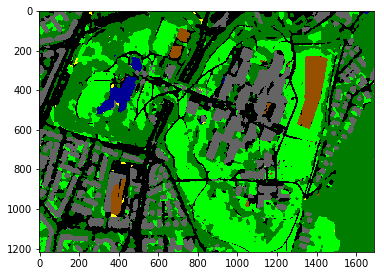

Running for Image 6.tif
../gen_test/generated_6.tif


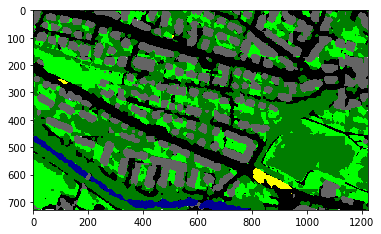

Running for Image 5.tif
../gen_test/generated_5.tif


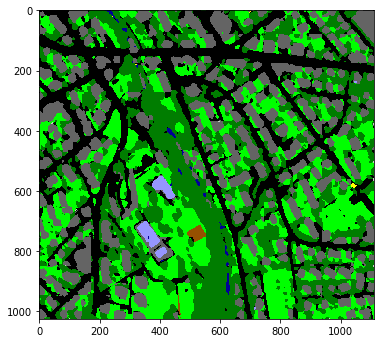

Running for Image 1.tif
../gen_test/generated_1.tif


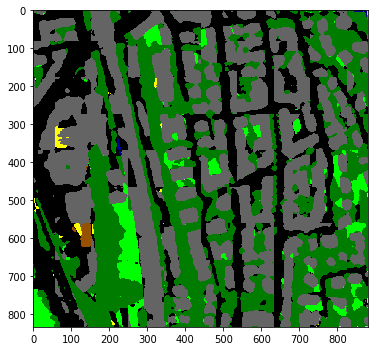

In [17]:
dir_name = "test_x/"##Folder in which test images are there
result_dir = "gen_test/"


#TO generate the predictions from each test iamge.
for img_name in os.listdir(dir_name):
    
        img_path = dir_name+img_name
        
        print("Running for Image "+str(img_name))
        
        preds_arr=[]

        
        for file_name in range(1,15):

            filepath= 'cv_weights/cv_weights_v_'+str(file_name)+'.best.hdf5'


            img = tiff.imread(img_path)
            im = np.copy(img)
            patch_size=96
            image=im[:,:,:]
            image=np.dot(image[...,:],[0.25,0.25,0.25,0.25])
            edge_sobel = sobel(image)
            edge_sobel = np.expand_dims(np.where(edge_sobel>80,4096,0),axis=2)
            old_size = im.shape[:2] # old_size is in (height, width) format
            delta_w = patch_size * (old_size[1]//patch_size) + patch_size  - old_size[1]
            delta_h = patch_size * (old_size[0]//patch_size)+ patch_size - old_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            color = [0,0,0]
            first_three_channels = cv2.copyMakeBorder(im[:,:,:3], top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
            color = [0]
            nir_channel = np.expand_dims(cv2.copyMakeBorder(im[:,:,3], top, bottom, left, right, cv2.BORDER_CONSTANT,value=color),axis=2)
            edge_channel = np.expand_dims(cv2.copyMakeBorder(edge_sobel, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color),axis=2)
            new_im = np.concatenate((first_three_channels,nir_channel,edge_channel),axis=2)

            

            
            if img.shape[0]%patch_size!=0 and img.shape[1]%patch_size!=0:
                img1 = generate_whole_mask(new_im,filepath)[ top:-bottom, left:- right]

            elif img.shape[0]%patch_size!=0 and img.shape[1]%patch_size==0:
                img1 = generate_whole_mask(new_im,filepath)[ top:-bottom, : ]


            elif img.shape[0]%patch_size==0 and img.shape[1]%patch_size!=0:
                img1 = generate_whole_mask(new_im,filepath)[ :, left:- right ]
                
            preds_arr.append(img1)
            
        gen = np.mean(preds_arr,axis=0)
        gen = np.argmax(gen,axis=2)
        
        inv_map = inverse_map(attheend(img,gen))
        
        print (result_dir+"generated_"+img_name)
        tiff.imsave(result_dir+"generated_"+img_name,inv_map)
            
        plt.close('all')
        plt.figure(figsize=(6,6))
       
        plt.imshow(inv_map)
        plt.show()

                
            